# Image Classification for Identification of Vespa Mandarinia


### Summary

This notebook contains code for a neural network model that yields probability estimates for presence of several different large hymenoptera, with the primary objective being correct prediction of vespa mandarinia for entomological and pest control purposes.

Architecture and approach draw heavily from [this pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

The core architecture is simple:

1. Use pretrained RestNet18
2. Freeze convolutional portion of network as a fixed feature extractor
3. Replace the final fully connected layer with a custom FC layer appropriate for the classification task at hand
4. Use cross entropy loss to output a prediction

### Data strategy

Model trained for classification of 6 classes:
- 'vespa_mandarinia'
- 'vespa_velutina', 'sphex_ichneumoneus', 'sphecius_speciosus', 'sphecius_grandis', 'tremex_columba']

Images used for training and validation are from Google search results for the respective class. **Currently data is very messy / noisy because it has not been thoroughly cleaned.**  The first part of the notebook performs data processing by parsing html files for image search results.


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io
import time
import os
import copy
import shutil
from bs4 import BeautifulSoup
import base64
from io import BytesIO
from PIL import Image
import requests
import asyncio
import aiohttp
from aiohttp import ClientSession, ClientConnectorError

plt.ion()   # interactive mode

In [20]:
def get_class_names():
    return ['vespa_mandarinia', 'vespa_velutina', 'sphex_ichneumoneus', 'sphecius_speciosus', 'sphecius_grandis', 'tremex_columba']

def is_base_64_image(text):
    return isinstance(text, str) and text.startswith('data:image/jpeg;base64')

def is_url_image(text):
    return isinstance(text, str) and text.startswith('http')

def get_base64_content(initial):
    return initial.split('data:image/jpeg;base64,')[1]

def get_image_type(src):
    if src == None:
        return {'ext': None, 'label': None}
    if 'jpeg' in src:
        return {'ext': 'jpg', 'label': 'JPEG'}
    elif src.startswith('https://'):
        # Key naming can be improved here (don't use "img")
        return {'ext': 'img', 'label': None}
    else:
        return {'ext': None, 'label': None}

def get_class_name_from_file(file_name: str):
    (class_name, ext) = file_name.split('.html')
    return class_name

def get_data_dir():
    raise Exception('Handle this without deleting cleaned data!')
    #return os.path.join(os.getcwd(), 'data', 'vespa_mandarinia_data')

def get_sample_file_name(file_name):
    data_dir = get_data_dir
    return os.path.join(data_dir, file_name)
    
async def seed_images():
    print('Seeding...')
    data_dir = get_data_dir()
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    os.mkdir(data_dir)
    await process_html_files()
    print('Seeding complete')

    
async def stream_to_data(stream):
    empty_bytes = b''
    result = empty_bytes
    while True:
        chunk = await stream.read(8)
        if chunk == empty_bytes:
            break
        result += chunk
    return result
    
async def make_file_from_base64(src_string: str, file_name: str):
    image_type = get_image_type(src_string)
    content = get_base64_content(src_string)
    decoded = base64.b64decode(content)
    bytes_data = BytesIO(decoded)
    image = Image.open(bytes_data)
    ext = image_type.get('ext')
    file_path = f'{file_name}.{ext}'
    image.save(file_path, image_type['label'])
    
async def make_file_from_url(url: str, file_name: str, session: ClientSession):
    try:
        resp = await session.request(method="GET", url=url)
        image_contents = await stream_to_data(resp.content)
        image = Image.open(BytesIO(image_contents))
        # TODO: handle other image types
        if image.format == 'JPEG':
            image.save(file_name + '.jpg', image.format)
    except ClientConnectorError:
        print('Error getting image: ', url)
        
async def make_requests(items, **kwargs) -> None:
    base64_tasks = []
    url_tasks = []

    for item in items:
        if item['request_type'] == 'base64':
            handler = make_file_from_base64(item['src'], item['file_name'])
            base64_tasks.append(handler)
        elif item['request_type'] == 'url':
            url_tasks.append(item)
      
    base64_results = await asyncio.gather(*base64_tasks)

    async with ClientSession() as session:
        tasks = []
        for item in url_tasks:
            tasks.append(
                make_file_from_url(item['src'], item['file_name'], session=session)
            )
        results = await asyncio.gather(*tasks)
        return results

async def process_html_files():
    # Put all required data fetching operations into a single
    # list to be processed downstream
    all_items = []
    # Html file names are equivalent to class names
    html_files = get_class_names()
    for file in html_files:
        class_name = file
        dir_path = os.path.join(get_data_dir(), class_name)
        path = os.path.join('data', 'html', f'{file}.html')
        items = process_html_file(path, class_name)
        all_items.append(items)
    # Flatten list
    all_items = [ item for item_group in all_items for item in item_group ]
    next_items = []
    count = 0
    for item in all_items:
        class_name = item['class_name']
        file_name = os.path.join(get_data_dir(), f"{class_name}-{count}")
        next_items.append({**item, 'file_name': file_name})    
        count += 1
            
    results = await make_requests(next_items)
                        
    

def process_html_file(file_name: str, class_name: str):
    with open(file_name, 'r') as file:
        soup = BeautifulSoup(file.read(), 'html.parser')

    el = soup.find(id="islrg")
    images = el.find_all('img')
    items = []

    for image in images:
        request_type = None
        src = image.get('src')
        if (is_base_64_image(src)):
            request_type = 'base64'
        elif is_url_image(src):
            request_type = 'url'
        item = {
            "src": image.get('src'),
            "alt": image.get('alt'),
            'class_name': class_name,
            "request_type": request_type
        }
        if item['request_type'] != None:
            items.append(item)
    return items


In [21]:
# Seed data
await seed_images()

Seeding...


Exception: Handle this without deleting cleaned data!

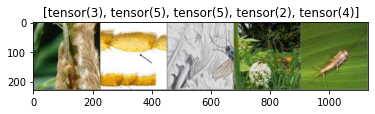

In [11]:
class PrimaryDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = [file for file in os.listdir(root_dir) if file.endswith('jpg')]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]


class DerivedDataset(Dataset):
    def __init__(self, subset, root_dir, transform=None):
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
        
    def image_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index):
        file_name = self.subset[index]
        class_name = file_name.split('-')[0]
        class_index = get_class_names().index(class_name)
        file_path = os.path.join(self.root_dir, file_name)
        image = self.image_loader(file_path)
        if self.transform:
            image = self.transform(image)
        return (image, class_index)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = PrimaryDataset(get_data_dir())
full_dataset_size = len(full_dataset)
train_size = int(0.8 * full_dataset_size)
validation_size = full_dataset_size - train_size

train_subset, validation_subset = torch.utils.data.random_split(
    full_dataset,
    [train_size, validation_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = DerivedDataset(train_subset, get_data_dir(), train_transform)
validation_dataset = DerivedDataset(validation_subset, get_data_dir(), validation_transform)

train_dataloader = DataLoader(train_dataset, batch_size=5)
validation_dataloader = DataLoader(validation_dataset, batch_size=5)

def imshow(inp, title=None):
    # Show image for tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title[0:10])
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, class_names = next(iter(train_dataloader))
inputs, class_names = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in range(len(class_names))])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 20)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
                dataset = train_dataset
            else:
                model.eval()
                dataloader = validation_dataloader
                dataset = validation_dataset
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass; track history only if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward and optimize only if training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            
            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double() / len(dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'validation' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_accuracy))
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [14]:
# Load pretrained model
model = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Freeze conv net parameters (we are using conv net of pretrained resnet18 as fixed feature extractor)
for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features
# Replace fully connected layer
model.fc = nn.Linear(num_features, len(get_class_names()))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

result = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
--------------------
train Loss: 1.7211 Acc: 0.3046
validation Loss: 1.4636 Acc: 0.4351

Epoch 2/20
--------------------
train Loss: 1.5437 Acc: 0.4135
validation Loss: 1.4174 Acc: 0.4789

Epoch 3/20
--------------------
train Loss: 1.5210 Acc: 0.4190
validation Loss: 1.3839 Acc: 0.4992

Epoch 4/20
--------------------
train Loss: 1.5155 Acc: 0.4329
validation Loss: 1.4019 Acc: 0.5093

Epoch 5/20
--------------------
train Loss: 1.4881 Acc: 0.4502
validation Loss: 1.3960 Acc: 0.5194

Epoch 6/20
--------------------
train Loss: 1.4755 Acc: 0.4582
validation Loss: 1.3496 Acc: 0.5346

Epoch 7/20
--------------------
train Loss: 1.4868 Acc: 0.4422
validation Loss: 1.4540 Acc: 0.5160

Epoch 8/20
--------------------
train Loss: 1.2982 Acc: 0.5080
validation Loss: 1.3526 Acc: 0.5194

Epoch 9/20
--------------------
train Loss: 1.2615 Acc: 0.5215
validation Loss: 1.3758 Acc: 0.5228

Epoch 10/20
--------------------
train Loss: 1.2814 Acc: 0.5110
validation Loss: 1.3404 Acc: 0.5261


In [18]:
# Save weights to file
path = 'data/model_state_dicts'
if not os.path.exists(path):
    os.mkdir(path)
torch.save(model.state_dict(), os.path.join(path, 'weights.pkl'))